In [1]:
from autoencoder import Autoencoder
from compute_results import plot_roc_curve, get_overall_metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import torch
import os

In [2]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Importing preprocessed data

In [3]:
PATH_TRAIN_AXAM_CSV = '../data/train_AxAm_preprocessed.csv'
PATH_TRAIN_AMAM_CSV = '../data/train_AmAm_preprocessed.csv'
PATH_VAL_CSV = '../data/val_preprocessed.csv'
PATH_TEST_CSV = '../data/test_preprocessed.csv'

df_train_AxAm = pd.read_csv(PATH_TRAIN_AXAM_CSV)
df_train_AmAm = pd.read_csv(PATH_TRAIN_AMAM_CSV)
df_val = pd.read_csv(PATH_VAL_CSV)
df_test = pd.read_csv(PATH_TEST_CSV)

In [4]:
def split_features_labels_and_domains_columns(df):
    X = df.drop(['domain', 'label'], axis='columns')
    y = df['label']
    domains = df['domain']
    return X,y,domains

X_train_AxAm, y_train_AxAm, domains_train_AxAm = split_features_labels_and_domains_columns(df_train_AxAm)
X_train_AmAm, y_train_AmAm, domains_train_AmAm = split_features_labels_and_domains_columns(df_train_AmAm)
X_val, y_val, domains_val = split_features_labels_and_domains_columns(df_val)
X_test, y_test, domains_test = split_features_labels_and_domains_columns(df_test)

## Preparing autoencoder training data

We must remove malicious instances for autoencoder training

In [5]:
X_train_AxAm_benign = X_train_AxAm[y_train_AxAm == 0].reset_index(drop=True)
X_train_AmAm_benign = X_train_AmAm[y_train_AmAm == 0].reset_index(drop=True)

In [6]:
X_train_AxAm_benign.shape, X_train_AmAm_benign.shape

((480000, 47), (655683, 47))

Normalizing

In [7]:
from sklearn.preprocessing import StandardScaler

# For AxAm training set
std_scaler_AxAm = StandardScaler()
std_scaler_AxAm = std_scaler_AxAm.fit(X_train_AxAm_benign)

X_train_AxAm_benign_norm = std_scaler_AxAm.transform(X_train_AxAm_benign)
X_val_AxAm_norm = std_scaler_AxAm.transform(X_val)
X_test_AxAm_norm = std_scaler_AxAm.transform(X_test)

X_train_AxAm_benign_norm = torch.tensor(X_train_AxAm_benign_norm, dtype=torch.float32)
X_val_AxAm_norm = torch.tensor(X_val_AxAm_norm, dtype=torch.float32)
X_test_AxAm_norm = torch.tensor(X_test_AxAm_norm, dtype=torch.float32)

In [8]:
# # For AmAm training set
std_scaler_AmAm = StandardScaler()
std_scaler_AmAm = std_scaler_AmAm.fit(X_train_AmAm_benign)

X_train_AmAm_benign_norm = std_scaler_AmAm.transform(X_train_AmAm_benign)
X_val_AmAm_norm = std_scaler_AmAm.transform(X_val)
X_test_AmAm_norm = std_scaler_AmAm.transform(X_test)

X_train_AmAm_benign_norm = torch.tensor(X_train_AmAm_benign_norm, dtype=torch.float32)
X_val_AmAm_norm = torch.tensor(X_val_AmAm_norm, dtype=torch.float32)
X_test_AmAm_norm = torch.tensor(X_test_AmAm_norm, dtype=torch.float32)

# Modelling with Autoencoder

In [9]:
HIDDEN_LAYERS_DIM = (40, 35, 25, 15, 10, 15, 25, 35, 40)
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 45
BATCH_SIZE = 128
PATIENCE = 6
DELTA = 0.002

## Training with AxAm dataset

In [10]:
# HIDDEN_LAYERS_DIM2 = (45, 40, 35, 25, 15, 10, 15, 25, 35, 40, 45)   # AUC=0.85780
# HIDDEN_LAYERS_DIM3 = (35, 20, 10, 20, 30)                           # AUC=0.85265
# HIDDEN_LAYERS_DIM4 = (32, 16, 8, 16, 32)                            # AUC=0.86286
# HIDDEN_LAYERS_DIM5 = (32, 16, 5, 16, 32)                            # AUC=0.87752

model_ae_AxAm = Autoencoder(in_features=X_train_AxAm.shape[1], 
                       hidden_layers_dims=HIDDEN_LAYERS_DIM,
                       dropout_rate=0.0)
model_ae_AxAm.compile(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model_ae_AxAm, train_avg_losses_AxAm, val_avg_losses_AxAm = model_ae_AxAm.fit(
                                                X_train=X_train_AxAm_benign_norm,
                                                num_epochs= NUM_EPOCHS,
                                                batch_size=BATCH_SIZE,
                                                X_val=X_val_AxAm_norm,
                                                y_val=y_val,
                                                patience=PATIENCE,
                                                delta=DELTA,
                                                es_criterion='aucroc'
                                            )

Using early stopping with patience=6, delta=0.002 and es_criterion=aucroc


100%|██████████| 3750/3750 [00:16<00:00, 232.89it/s]


Epoch#1: Train Average Loss = 0.61672
Validation score improved (-inf --> 0.81948).  Saving model ...


100%|██████████| 3750/3750 [00:11<00:00, 326.51it/s]


Epoch#2: Train Average Loss = 0.51787
Validation score improved (0.81948 --> 0.82185).  Saving model ...


100%|██████████| 3750/3750 [00:22<00:00, 168.96it/s]


Epoch#3: Train Average Loss = 0.48777
EarlyStopping counter: 1 out of 6. Current validation score: 0.81456


100%|██████████| 3750/3750 [00:21<00:00, 176.01it/s]


Epoch#4: Train Average Loss = 0.46697
EarlyStopping counter: 2 out of 6. Current validation score: 0.80325


100%|██████████| 3750/3750 [00:20<00:00, 181.76it/s]


Epoch#5: Train Average Loss = 0.43598
EarlyStopping counter: 3 out of 6. Current validation score: 0.79802


100%|██████████| 3750/3750 [00:23<00:00, 161.95it/s]


Epoch#6: Train Average Loss = 0.42480
EarlyStopping counter: 4 out of 6. Current validation score: 0.79582


100%|██████████| 3750/3750 [00:24<00:00, 152.88it/s]


Epoch#7: Train Average Loss = 0.41830
EarlyStopping counter: 5 out of 6. Current validation score: 0.79631


100%|██████████| 3750/3750 [00:25<00:00, 146.72it/s]


Epoch#8: Train Average Loss = 0.41368
EarlyStopping counter: 6 out of 6. Current validation score: 0.79604


100%|██████████| 3750/3750 [00:30<00:00, 124.94it/s]


Epoch#9: Train Average Loss = 0.41020
EarlyStopping counter: 7 out of 6. Current validation score: 0.79460
Stopped by early stopping at epoch 9


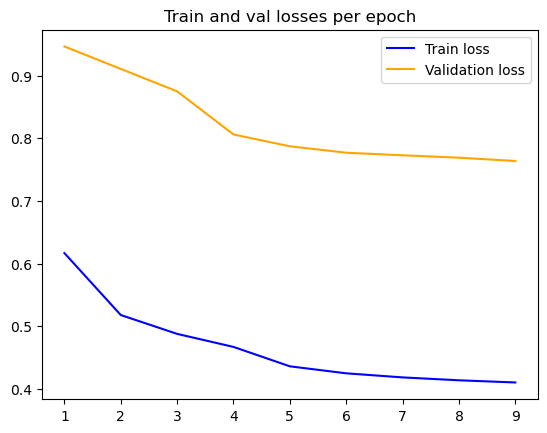

In [11]:
def plot_train_val_losses(train_avg_losses, val_avg_losses):
  epochs = list(range(1, len(train_avg_losses)+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Train loss')
  plt.plot(epochs, val_avg_losses, color='orange', label='Validation loss')
  plt.title('Train and val losses per epoch')
  plt.legend()

plot_train_val_losses(train_avg_losses_AxAm, val_avg_losses_AxAm)

## Training with AmAm dataset

In [12]:
model_ae_AmAm = Autoencoder(in_features=X_train_AmAm.shape[1], 
                       hidden_layers_dims=HIDDEN_LAYERS_DIM,
                       dropout_rate=0.0)
model_ae_AmAm.compile(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model_ae_AmAm, train_avg_losses_AmAm, val_avg_losses_AmAm = model_ae_AmAm.fit(
                                                X_train=X_train_AmAm_benign_norm,
                                                num_epochs= NUM_EPOCHS,
                                                batch_size=BATCH_SIZE,
                                                X_val=X_val_AmAm_norm,
                                                y_val=y_val,
                                                patience=PATIENCE,
                                                delta=DELTA,
                                                es_criterion='aucroc'
                                            )

Using early stopping with patience=6, delta=0.002 and es_criterion=aucroc


100%|██████████| 5123/5123 [00:19<00:00, 259.03it/s]


Epoch#1: Train Average Loss = 1.00018
Validation score improved (-inf --> 0.74428).  Saving model ...


100%|██████████| 5123/5123 [00:23<00:00, 220.31it/s]


Epoch#2: Train Average Loss = 1.00008
EarlyStopping counter: 1 out of 6. Current validation score: 0.74433


100%|██████████| 5123/5123 [00:22<00:00, 229.39it/s]


Epoch#3: Train Average Loss = 1.00007
EarlyStopping counter: 2 out of 6. Current validation score: 0.74435


100%|██████████| 5123/5123 [00:20<00:00, 247.99it/s]


Epoch#4: Train Average Loss = 1.00006
EarlyStopping counter: 3 out of 6. Current validation score: 0.74435


100%|██████████| 5123/5123 [00:20<00:00, 252.28it/s]


Epoch#5: Train Average Loss = 1.00006
EarlyStopping counter: 4 out of 6. Current validation score: 0.74434


100%|██████████| 5123/5123 [00:20<00:00, 252.90it/s]


Epoch#6: Train Average Loss = 1.00005
EarlyStopping counter: 5 out of 6. Current validation score: 0.74435


100%|██████████| 5123/5123 [00:22<00:00, 230.38it/s]


Epoch#7: Train Average Loss = 1.00005
EarlyStopping counter: 6 out of 6. Current validation score: 0.74435


100%|██████████| 5123/5123 [00:21<00:00, 237.29it/s]


Epoch#8: Train Average Loss = 1.00005
EarlyStopping counter: 7 out of 6. Current validation score: 0.74435
Stopped by early stopping at epoch 8


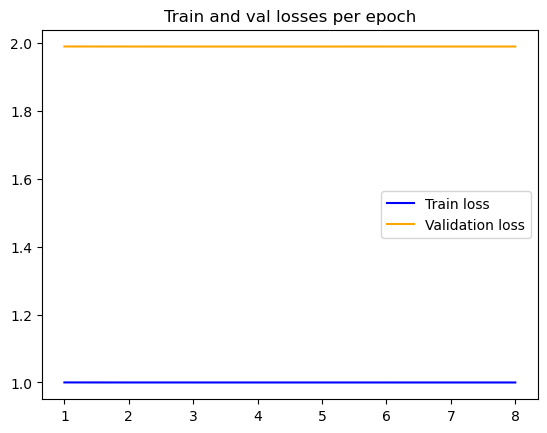

In [13]:
plot_train_val_losses(train_avg_losses_AmAm, val_avg_losses_AmAm)

# Defining a threshold and computing results

In [14]:
def get_autoencoder_anomaly_scores(model_ae, X):
  X = torch.FloatTensor(X)
  reconstructed_X = model_ae(X)
  anomaly_scores = torch.mean(torch.pow(X - reconstructed_X, 2), axis=1).detach().numpy() # MSELoss
  return anomaly_scores

## AxAm dataset used as train

### Validation Set

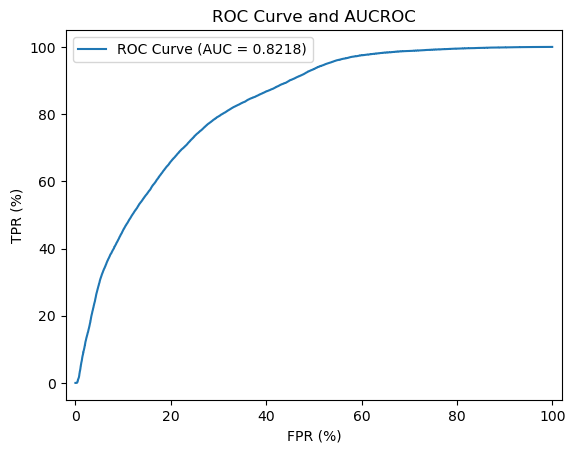

In [15]:
val_anomaly_scores_AxAm = get_autoencoder_anomaly_scores(model_ae_AxAm, X_val_AxAm_norm)
plot_roc_curve(y_val, val_anomaly_scores_AxAm)

In [16]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores_AxAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
BEST_VALIDATION_THRESHOLD_AXAM = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').iloc[0]['thresholds']

In [17]:
get_overall_metrics(y_val, val_anomaly_scores_AxAm > BEST_VALIDATION_THRESHOLD_AXAM)

{'acc': 0.7233307692307692,
 'tpr': 0.7909,
 'fpr': 0.29694,
 'precision': 0.4441511765036222,
 'f1-score': 0.5688495702520947}

### Test set

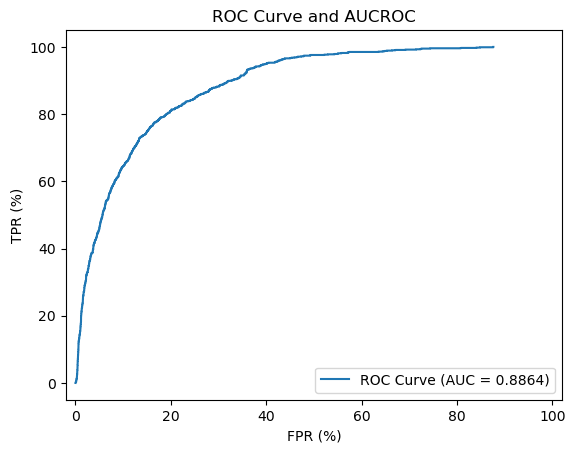

In [18]:
test_anomaly_scores_AxAm = get_autoencoder_anomaly_scores(model_ae_AxAm, X_test_AxAm_norm)
plot_roc_curve(y_test, test_anomaly_scores_AxAm)

In [19]:
get_overall_metrics(y_test, test_anomaly_scores_AxAm > BEST_VALIDATION_THRESHOLD_AXAM)

{'acc': 0.8065,
 'tpr': 0.801,
 'fpr': 0.1928888888888889,
 'precision': 0.31572723689396925,
 'f1-score': 0.4529262086513995}

In [20]:
# best_possible_test_threshold

fpr, tpr, thresholds = roc_curve(y_test, test_anomaly_scores_AxAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
best_possible_test_threshold_AxAm = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').iloc[0]['thresholds']

In [21]:
get_overall_metrics(y_test, test_anomaly_scores_AxAm > best_possible_test_threshold_AxAm)

{'acc': 0.7999,
 'tpr': 0.813,
 'fpr': 0.20155555555555554,
 'precision': 0.30947849257708415,
 'f1-score': 0.44830438378825477}

## AmAm dataset used as train

### Validation Set

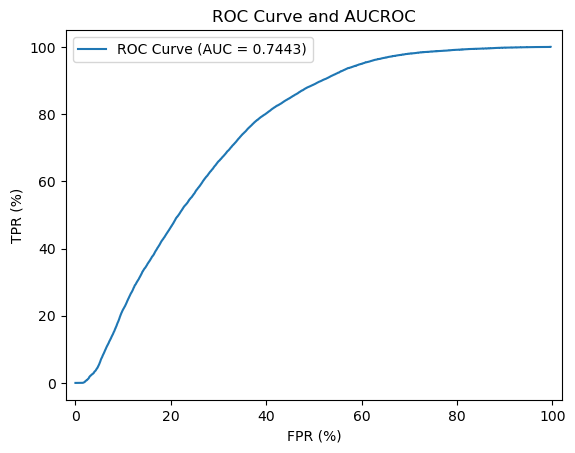

In [22]:
val_anomaly_scores_AmAm = get_autoencoder_anomaly_scores(model_ae_AmAm, X_val_AmAm_norm)
plot_roc_curve(y_val, val_anomaly_scores_AmAm)

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, val_anomaly_scores_AmAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
29935,0.41410,0.817300,0.801011,0.403200
29899,0.41335,0.816533,0.802276,0.403183
29897,0.41332,0.816500,0.802319,0.403180
29931,0.41399,0.817167,0.801216,0.403177
29933,0.41406,0.817233,0.801063,0.403173
...,...,...,...,...
246,0.01928,0.002767,9.923044,-0.016513
242,0.01920,0.002667,9.947595,-0.016533
230,0.01894,0.002400,10.063828,-0.016540
232,0.01898,0.002433,10.047294,-0.016547


In [24]:
BEST_VALIDATION_THRESHOLD_AMAM = 0.801011	

In [25]:
get_overall_metrics(y_val, val_anomaly_scores_AxAm > BEST_VALIDATION_THRESHOLD_AMAM)

{'acc': 0.7824076923076924,
 'tpr': 0.5715,
 'fpr': 0.15432,
 'precision': 0.5262915553918409,
 'f1-score': 0.5479649072342874}

### Test set

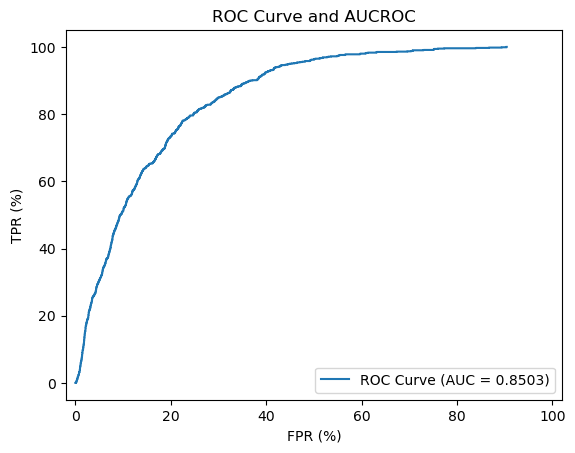

In [26]:
test_anomaly_scores_AmAm = get_autoencoder_anomaly_scores(model_ae_AmAm, X_test_AmAm_norm)
plot_roc_curve(y_test, test_anomaly_scores_AmAm)

In [27]:
get_overall_metrics(y_test, test_anomaly_scores_AxAm > BEST_VALIDATION_THRESHOLD_AMAM)

{'acc': 0.8878,
 'tpr': 0.591,
 'fpr': 0.07922222222222222,
 'precision': 0.4532208588957055,
 'f1-score': 0.5130208333333334}

In [28]:
# best_possible_test_threshold

fpr, tpr, thresholds = roc_curve(y_test, test_anomaly_scores_AmAm)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
best_possible_test_threshold_AmAm = df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').iloc[0]['thresholds']

In [29]:
get_overall_metrics(y_test, test_anomaly_scores_AxAm > best_possible_test_threshold_AmAm)

{'acc': 0.8902,
 'tpr': 0.576,
 'fpr': 0.0748888888888889,
 'precision': 0.4608,
 'f1-score': 0.5119999999999999}